Neural net for predicting fraudulent transactions using [Kaggle Fraudulent Transactions Data](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download).

Importing necessary librarys.

Historic versions

In [97]:
hyperparameters = pd.DataFrame([[1,"Initial","binary_crossentropy",0.01,"RMSprop",20,256,0.2,(1,1),0.5],
                               [2,"Weight class","binary_crossentropy",0.001,"RMSprop",100,256,0.2,(1,77.1046),0.5],
                               [3,"Undersampling","binary_crossentropy",0.0003,"RMSprop",200,256,0.2,(1,1),0.5]],
                                columns=['iter','comment','loss','learning_rate','optimizer','epochs','batch_size', 'validation_split','class_weghts','tp_threshold'])

metrics = pd.DataFrame([[0.004541558679193258,0.02667786367237568,0.41296297311782837,0.9151846766471863,0.6184723377227783],
                       [0.021265724673867226,0.055535029619932175,0.6895061731338501,0.3480835258960724,0.6146407127380371],
                       [0.033423855900764465,0.07861153781414032,0.7685185074806213,0.1780606359243393,0.5602833032608032]],
                        columns=['loss','root_mean_squared_error','recall','precision','AUC'])


In [98]:
test_scores

[0.033423855900764465,
 0.07861153781414032,
 0.7685185074806213,
 0.1780606359243393,
 0.5602833032608032]

In [99]:
pd.concat([hyperparameters,metrics],axis=1)

,iter,comment,loss,learning_rate,optimizer,epochs,batch_size,validation_split,class_weghts,tp_threshold,loss,root_mean_squared_error,recall,precision,AUC
0,1,Initial,binary_crossentropy,0.0100,RMSprop,20,256,0.2,"(1, 1)",0.5,0.004542,0.026678,0.412963,0.915185,0.618472
1,2,Weight class,binary_crossentropy,0.0010,RMSprop,100,256,0.2,"(1, 77.1046)",0.5,0.021266,0.055535,0.689506,0.348084,0.614641
2,3,Undersampling,binary_crossentropy,0.0003,RMSprop,200,256,0.2,"(1, 1)",0.5,0.033424,0.078612,0.768519,0.178061,0.560283


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import scipy as sp
import seaborn as sns

Downloading data

In [2]:
df=pd.read_csv('C:/Users/T440s/Kaggle/archive/fraudulent_transaction_data.csv')

Getting to know the data set.

In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
'Number of cases where transaction originator is not Customer: {}'.format(len(df[df["nameOrig"].str.get(0) != "C"]))

'Number of cases where transaction originator is not Customer: 0'

Dataset doesn't have any missing data fields. Balance is missing for Merchant type persons. Merchants only on the Dest side.

Let's use this plot from the internet to illustrate how a model is performing.

In [6]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

### Feature engineering

Next up, we'll be adding additional parameters to our model, but for that we have to change them a little bit.

##### `step`
We will leave this out for now, as it seems to be a strong but not most realistic predictor (most of the fraud takes place in low steps.

##### `type`
This categorical value needs to be formated to use in the model. We'll use one hot encoding.

##### `amount`
As we now have other attributes in the model, `amount` should be normalised.

##### `nameOrig`
We'll discard this for now.

##### `oldbalanceOrg`
Will rename it to  `oldbalanceOrig` and normalize.

##### `newbalanceOrig`
Have to normalize this.

##### `nameDest`
We'll discard this for now, but calculate new features `customerDest` (1 if C) and `merchantDest` (1 if M).

##### `oldbalanceDest`
Have to normalize this. As the balance is 0 for all merchants, as it is unknown, other substitutes should be considered.

##### `newbalanceDest`
Have to normalize this. As the balance is 0 for all merchants, as it is unknown, other substitutes should be considered.


Will use `isFraud` as the label.

In [7]:
X = df[["type","amount","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest"]]
X = X.rename(columns={"oldbalanceOrg": "oldbalanceOrig"})
X["customerDest"] = (X["nameDest"].str.get(0) == "C").astype(float)
X["merchantDest"] = (X["nameDest"].str.get(0) == "M").astype(float)
X = X.drop(columns=["nameDest"])
y = df[["isFraud"]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Defining a preprocessing layer so that it will be easier to modify and apply in testing.

In [9]:
columns = np.array(X_train.columns)
features_to_scale = ["amount","oldbalanceOrig","newbalanceOrig","oldbalanceDest","newbalanceDest"]

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
        ('OHE', OneHotEncoder(sparse_output=False), ["type"]),
        ('passthrough', 'passthrough', ["customerDest", "merchantDest"])
    ],
    remainder='drop'  # Drop any columns not explicitly specified
).set_output(transform="pandas")

# Fit the ColumnTransformer and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

In [10]:
print('X_train_transformed: {}'.format(X_train_transformed.shape))
X_train_transformed.head()

X_train_transformed: (5090096, 12)


,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
6271196,0.343453,1.328802,1.437536,-0.174992,-0.301147,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1888243,0.054355,-0.207401,-0.139419,-0.086546,-0.171883,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5549957,-0.265601,-0.287416,-0.292395,-0.324181,-0.333782,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2025342,0.578206,-0.226251,-0.292395,-0.297011,-0.164739,0.0,1.0,0.0,0.0,0.0,1.0,0.0
682342,0.043732,-0.288675,-0.292395,0.304224,0.303786,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [11]:
X_train_transformed.describe()

,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
count,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06
mean,1.171885e-17,3.435367e-16,-6.574246e-17,-7.196587e-16,1.418490e-16,2.198748e-01,3.517788e-01,6.520899e-03,3.380478e-01,8.377759e-02,6.619522e-01,3.380478e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.141617e-01,4.775254e-01,8.048837e-02,4.730450e-01,2.770540e-01,4.730450e-01,4.730450e-01
min,-2.987904e-01,-2.886750e-01,-2.923954e-01,-3.241808e-01,-3.337815e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-2.765242e-01,-2.886750e-01,-2.923954e-01,-3.241808e-01,-3.337815e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-1.743509e-01,-2.837629e-01,-2.923954e-01,-2.850611e-01,-2.752718e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,4.801567e-02,-2.515057e-01,-2.430638e-01,-4.653224e-02,-3.075325e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,1.533627e+02,2.035079e+01,1.667349e+01,1.046361e+02,9.681375e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As we can see, there are still some very large values in the data set, that need some further exploration.

Defining simple model using just one layer.

In [12]:
inputs = tf.keras.Input(shape=(X_train_transformed.shape[1],))

In [13]:
dense = tf.keras.layers.Dense(1,activation = 'sigmoid')

In [14]:
outputs = dense(inputs)

In [15]:
simple_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="simple_model")

In [16]:
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As the loss has been unstable for larger learning rates (loss will start to grow after some epochs), a relatively small learning rate has to be used, thus increasing the number of epochs needed. Other optimizers should be tested to see if they perform better with this problem.

In [84]:
simple_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(reduction="sum_over_batch_size", name="binary_crossentropy"),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0003),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.AUC(curve="PR",name="AUC")]#[tf.keras.metrics.SparseCategoricalAccuracy()],
)

We will take the actual bias as parameter when trying to tackle that with weighing or sampling.

In [44]:
neg, pos = np.bincount(y_train["isFraud"])
total = pos + neg
'neg_cases: {}, pos_cases: {}, pos_prop: {:.3f}'.format(neg,pos,pos/(total))

'neg_cases: 5083503, pos_cases: 6593, pos_prop: 0.001'

As the training data is heavily biased towards negative cases, we will use underfiting for negative class. Initially we can try something that reduces the bias to something like 10-to-1. This can lead to some issues if we lose some complexity in the data, but on the other side, this will help with model runtime and enables us to make more iterations with different hyperparameters.

In [75]:
y_train_us = y_train.copy()
X_train_us = X_train_transformed.copy()
y_train_us["RowID"] = y_train_us.index
X_train_us["RowID"] = X_train_transformed.index
y_train_us_neg = y_train_us[y_train_us["isFraud"] == 0].sample(frac=(9*pos)/total, random_state=42)

y_train_us = pd.concat([y_train_us[y_train_us["isFraud"] == 1], y_train_us_neg], ignore_index=True)
X_train_us = X_train_us.merge(y_train_us, on="RowID", how="inner")
y_train_us = pd.DataFrame(X_train_us.pop("isFraud"),columns=["isFraud"])
X_train_us.drop(columns="RowID",inplace=True)

Just because how much more efficient it is, some undersampling probably has to be used in this case. But it may be beneficial to find a sweet spot in using both undersampling and weighted positive class in some degree.

In [76]:
neg_us, pos_us = np.bincount(y_train_us["isFraud"])
total_us = pos_us + neg_us
'Undersampled: neg_cases: {}, pos_cases: {}, pos_prop: {:.3f}'.format(neg_us,pos_us,pos_us/(total_us))

'Undersampled: neg_cases: 59260, pos_cases: 6593, pos_prop: 0.100'

In [47]:
class_weights = {0: 1.,
                 1: 1}

Running the model for 200 epochs. The validation split gets the last 20% of records from the test data, but that might not be the best approach, but that introduces some weird behaviors in metrics. Probably because of some time dependencies in the data.

In [90]:
history = simple_model.fit(X_train_us, y_train_us,
                           batch_size=256, epochs=500, validation_split=0.2, class_weight = class_weights)

Epoch 1/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0947 - root_mean_squared_error: 0.1473 - recall: 0.7554 - precision: 0.9504 - AUC: 0.9381 - val_loss: 0.0920 - val_root_mean_squared_error: 0.1486 - val_recall: 0.7583 - val_precision: 0.9379 - val_AUC: 0.9323
Epoch 2/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0946 - root_mean_squared_error: 0.1473 - recall: 0.7554 - precision: 0.9506 - AUC: 0.9380 - val_loss: 0.0920 - val_root_mean_squared_error: 0.1486 - val_recall: 0.7583 - val_precision: 0.9379 - val_AUC: 0.9322
Epoch 3/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0946 - root_mean_squared_error: 0.1473 - recall: 0.7556 - precision: 0.9506 - AUC: 0.9381 - val_loss: 0.0920 - val_root_mean_squared_error: 0.1486 - val_recall: 0.7583 - val_precision: 0.9379 - val_AUC: 0.9323
Epoch 4/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0945 - root_mean_squared_error: 0.1473 - recall: 0.7554 - prec

206/206 [==============================] - 1s 2ms/step - loss: 0.0935 - root_mean_squared_error: 0.1472 - recall: 0.7563 - precision: 0.9500 - AUC: 0.9380 - val_loss: 0.0914 - val_root_mean_squared_error: 0.1487 - val_recall: 0.7583 - val_precision: 0.9370 - val_AUC: 0.9321
Epoch 30/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0935 - root_mean_squared_error: 0.1472 - recall: 0.7559 - precision: 0.9502 - AUC: 0.9380 - val_loss: 0.0914 - val_root_mean_squared_error: 0.1486 - val_recall: 0.7583 - val_precision: 0.9370 - val_AUC: 0.9322
Epoch 31/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0934 - root_mean_squared_error: 0.1472 - recall: 0.7571 - precision: 0.9498 - AUC: 0.9381 - val_loss: 0.0914 - val_root_mean_squared_error: 0.1486 - val_recall: 0.7583 - val_precision: 0.9370 - val_AUC: 0.9322
Epoch 32/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0934 - root_mean_squared_error: 0.1472 - recall: 0.7575 - precision: 0.

206/206 [==============================] - 0s 2ms/step - loss: 0.0925 - root_mean_squared_error: 0.1472 - recall: 0.7561 - precision: 0.9502 - AUC: 0.9381 - val_loss: 0.0909 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7591 - val_precision: 0.9362 - val_AUC: 0.9327
Epoch 58/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0925 - root_mean_squared_error: 0.1471 - recall: 0.7584 - precision: 0.9492 - AUC: 0.9381 - val_loss: 0.0909 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7583 - val_precision: 0.9361 - val_AUC: 0.9327
Epoch 59/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0925 - root_mean_squared_error: 0.1472 - recall: 0.7567 - precision: 0.9500 - AUC: 0.9381 - val_loss: 0.0909 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7598 - val_precision: 0.9363 - val_AUC: 0.9328
Epoch 60/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0924 - root_mean_squared_error: 0.1472 - recall: 0.7571 - precision: 0.

206/206 [==============================] - 0s 2ms/step - loss: 0.0916 - root_mean_squared_error: 0.1471 - recall: 0.7569 - precision: 0.9491 - AUC: 0.9382 - val_loss: 0.0907 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7606 - val_precision: 0.9354 - val_AUC: 0.9329
Epoch 86/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0915 - root_mean_squared_error: 0.1471 - recall: 0.7569 - precision: 0.9491 - AUC: 0.9382 - val_loss: 0.0907 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9328
Epoch 87/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0915 - root_mean_squared_error: 0.1472 - recall: 0.7567 - precision: 0.9491 - AUC: 0.9382 - val_loss: 0.0907 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7629 - val_precision: 0.9356 - val_AUC: 0.9328
Epoch 88/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0915 - root_mean_squared_error: 0.1471 - recall: 0.7578 - precision: 0.

206/206 [==============================] - 0s 2ms/step - loss: 0.0906 - root_mean_squared_error: 0.1471 - recall: 0.7571 - precision: 0.9485 - AUC: 0.9383 - val_loss: 0.0905 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9328
Epoch 114/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0906 - root_mean_squared_error: 0.1471 - recall: 0.7576 - precision: 0.9483 - AUC: 0.9382 - val_loss: 0.0905 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9328
Epoch 115/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0905 - root_mean_squared_error: 0.1471 - recall: 0.7575 - precision: 0.9487 - AUC: 0.9383 - val_loss: 0.0905 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9329
Epoch 116/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0905 - root_mean_squared_error: 0.1471 - recall: 0.7575 - precision:

206/206 [==============================] - 1s 3ms/step - loss: 0.0897 - root_mean_squared_error: 0.1470 - recall: 0.7576 - precision: 0.9492 - AUC: 0.9384 - val_loss: 0.0903 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9327
Epoch 142/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0897 - root_mean_squared_error: 0.1470 - recall: 0.7584 - precision: 0.9490 - AUC: 0.9384 - val_loss: 0.0903 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9327
Epoch 143/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0897 - root_mean_squared_error: 0.1470 - recall: 0.7582 - precision: 0.9490 - AUC: 0.9383 - val_loss: 0.0903 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7622 - val_precision: 0.9355 - val_AUC: 0.9328
Epoch 144/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0896 - root_mean_squared_error: 0.1470 - recall: 0.7578 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0890 - root_mean_squared_error: 0.1470 - recall: 0.7586 - precision: 0.9483 - AUC: 0.9384 - val_loss: 0.0902 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7637 - val_precision: 0.9348 - val_AUC: 0.9320
Epoch 170/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0889 - root_mean_squared_error: 0.1470 - recall: 0.7586 - precision: 0.9485 - AUC: 0.9384 - val_loss: 0.0901 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7629 - val_precision: 0.9347 - val_AUC: 0.9328
Epoch 171/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0889 - root_mean_squared_error: 0.1469 - recall: 0.7590 - precision: 0.9486 - AUC: 0.9385 - val_loss: 0.0901 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7629 - val_precision: 0.9347 - val_AUC: 0.9329
Epoch 172/500
206/206 [==============================] - 1s 4ms/step - loss: 0.0889 - root_mean_squared_error: 0.1469 - recall: 0.7586 - precision:

206/206 [==============================] - 1s 2ms/step - loss: 0.0882 - root_mean_squared_error: 0.1469 - recall: 0.7595 - precision: 0.9486 - AUC: 0.9387 - val_loss: 0.0899 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7629 - val_precision: 0.9347 - val_AUC: 0.9320
Epoch 198/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0882 - root_mean_squared_error: 0.1469 - recall: 0.7590 - precision: 0.9486 - AUC: 0.9386 - val_loss: 0.0899 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7629 - val_precision: 0.9347 - val_AUC: 0.9321
Epoch 199/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0882 - root_mean_squared_error: 0.1470 - recall: 0.7586 - precision: 0.9485 - AUC: 0.9387 - val_loss: 0.0899 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7637 - val_precision: 0.9348 - val_AUC: 0.9321
Epoch 200/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0881 - root_mean_squared_error: 0.1470 - recall: 0.7582 - precision:

206/206 [==============================] - 1s 3ms/step - loss: 0.0876 - root_mean_squared_error: 0.1468 - recall: 0.7597 - precision: 0.9484 - AUC: 0.9389 - val_loss: 0.0898 - val_root_mean_squared_error: 0.1484 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9322
Epoch 226/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0876 - root_mean_squared_error: 0.1468 - recall: 0.7603 - precision: 0.9487 - AUC: 0.9388 - val_loss: 0.0898 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9321
Epoch 227/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0876 - root_mean_squared_error: 0.1468 - recall: 0.7599 - precision: 0.9484 - AUC: 0.9389 - val_loss: 0.0898 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9322
Epoch 228/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0876 - root_mean_squared_error: 0.1468 - recall: 0.7603 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0871 - root_mean_squared_error: 0.1467 - recall: 0.7610 - precision: 0.9483 - AUC: 0.9392 - val_loss: 0.0896 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9331
Epoch 254/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0871 - root_mean_squared_error: 0.1467 - recall: 0.7620 - precision: 0.9483 - AUC: 0.9392 - val_loss: 0.0896 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9331
Epoch 255/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0871 - root_mean_squared_error: 0.1467 - recall: 0.7614 - precision: 0.9485 - AUC: 0.9393 - val_loss: 0.0895 - val_root_mean_squared_error: 0.1483 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9331
Epoch 256/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0871 - root_mean_squared_error: 0.1467 - recall: 0.7616 - precision:

206/206 [==============================] - 1s 3ms/step - loss: 0.0868 - root_mean_squared_error: 0.1466 - recall: 0.7620 - precision: 0.9490 - AUC: 0.9395 - val_loss: 0.0894 - val_root_mean_squared_error: 0.1482 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9334
Epoch 282/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0867 - root_mean_squared_error: 0.1466 - recall: 0.7620 - precision: 0.9488 - AUC: 0.9396 - val_loss: 0.0894 - val_root_mean_squared_error: 0.1482 - val_recall: 0.7668 - val_precision: 0.9350 - val_AUC: 0.9334
Epoch 283/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0867 - root_mean_squared_error: 0.1466 - recall: 0.7624 - precision: 0.9486 - AUC: 0.9395 - val_loss: 0.0894 - val_root_mean_squared_error: 0.1482 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9334
Epoch 284/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0867 - root_mean_squared_error: 0.1465 - recall: 0.7627 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0864 - root_mean_squared_error: 0.1465 - recall: 0.7635 - precision: 0.9489 - AUC: 0.9399 - val_loss: 0.0892 - val_root_mean_squared_error: 0.1482 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9335
Epoch 310/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0863 - root_mean_squared_error: 0.1465 - recall: 0.7629 - precision: 0.9490 - AUC: 0.9399 - val_loss: 0.0892 - val_root_mean_squared_error: 0.1482 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9335
Epoch 311/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0863 - root_mean_squared_error: 0.1465 - recall: 0.7626 - precision: 0.9497 - AUC: 0.9399 - val_loss: 0.0892 - val_root_mean_squared_error: 0.1481 - val_recall: 0.7653 - val_precision: 0.9340 - val_AUC: 0.9335
Epoch 312/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0863 - root_mean_squared_error: 0.1465 - recall: 0.7620 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0861 - root_mean_squared_error: 0.1463 - recall: 0.7643 - precision: 0.9502 - AUC: 0.9402 - val_loss: 0.0891 - val_root_mean_squared_error: 0.1481 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9338
Epoch 338/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0861 - root_mean_squared_error: 0.1463 - recall: 0.7643 - precision: 0.9500 - AUC: 0.9403 - val_loss: 0.0891 - val_root_mean_squared_error: 0.1481 - val_recall: 0.7645 - val_precision: 0.9348 - val_AUC: 0.9339
Epoch 339/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0861 - root_mean_squared_error: 0.1463 - recall: 0.7631 - precision: 0.9502 - AUC: 0.9402 - val_loss: 0.0891 - val_root_mean_squared_error: 0.1481 - val_recall: 0.7653 - val_precision: 0.9349 - val_AUC: 0.9339
Epoch 340/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0861 - root_mean_squared_error: 0.1463 - recall: 0.7635 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0859 - root_mean_squared_error: 0.1462 - recall: 0.7643 - precision: 0.9505 - AUC: 0.9407 - val_loss: 0.0890 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7645 - val_precision: 0.9348 - val_AUC: 0.9342
Epoch 366/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0859 - root_mean_squared_error: 0.1462 - recall: 0.7643 - precision: 0.9505 - AUC: 0.9408 - val_loss: 0.0889 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7660 - val_precision: 0.9341 - val_AUC: 0.9342
Epoch 367/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0859 - root_mean_squared_error: 0.1462 - recall: 0.7639 - precision: 0.9504 - AUC: 0.9408 - val_loss: 0.0889 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7653 - val_precision: 0.9340 - val_AUC: 0.9342
Epoch 368/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0859 - root_mean_squared_error: 0.1462 - recall: 0.7641 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0857 - root_mean_squared_error: 0.1462 - recall: 0.7643 - precision: 0.9505 - AUC: 0.9409 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7660 - val_precision: 0.9341 - val_AUC: 0.9345
Epoch 394/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0857 - root_mean_squared_error: 0.1461 - recall: 0.7650 - precision: 0.9505 - AUC: 0.9410 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7660 - val_precision: 0.9341 - val_AUC: 0.9345
Epoch 395/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0857 - root_mean_squared_error: 0.1462 - recall: 0.7646 - precision: 0.9505 - AUC: 0.9410 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1479 - val_recall: 0.7653 - val_precision: 0.9340 - val_AUC: 0.9346
Epoch 396/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0857 - root_mean_squared_error: 0.1462 - recall: 0.7644 - precision:

206/206 [==============================] - 1s 2ms/step - loss: 0.0855 - root_mean_squared_error: 0.1461 - recall: 0.7652 - precision: 0.9505 - AUC: 0.9411 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9346
Epoch 422/500
206/206 [==============================] - 1s 3ms/step - loss: 0.0855 - root_mean_squared_error: 0.1461 - recall: 0.7643 - precision: 0.9505 - AUC: 0.9411 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9346
Epoch 423/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0855 - root_mean_squared_error: 0.1461 - recall: 0.7648 - precision: 0.9505 - AUC: 0.9411 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9345
Epoch 424/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0855 - root_mean_squared_error: 0.1461 - recall: 0.7650 - precision:

206/206 [==============================] - 0s 2ms/step - loss: 0.0853 - root_mean_squared_error: 0.1461 - recall: 0.7654 - precision: 0.9505 - AUC: 0.9412 - val_loss: 0.0886 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9346
Epoch 450/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0853 - root_mean_squared_error: 0.1461 - recall: 0.7652 - precision: 0.9505 - AUC: 0.9412 - val_loss: 0.0886 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9350 - val_AUC: 0.9347
Epoch 451/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0853 - root_mean_squared_error: 0.1461 - recall: 0.7654 - precision: 0.9505 - AUC: 0.9412 - val_loss: 0.0886 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7660 - val_precision: 0.9341 - val_AUC: 0.9347
Epoch 452/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0853 - root_mean_squared_error: 0.1461 - recall: 0.7648 - precision:

206/206 [==============================] - 1s 3ms/step - loss: 0.0852 - root_mean_squared_error: 0.1461 - recall: 0.7644 - precision: 0.9512 - AUC: 0.9412 - val_loss: 0.0886 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7668 - val_precision: 0.9324 - val_AUC: 0.9346
Epoch 478/500
206/206 [==============================] - 0s 2ms/step - loss: 0.0852 - root_mean_squared_error: 0.1461 - recall: 0.7654 - precision: 0.9503 - AUC: 0.9413 - val_loss: 0.0885 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7668 - val_precision: 0.9324 - val_AUC: 0.9346
Epoch 479/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0851 - root_mean_squared_error: 0.1460 - recall: 0.7658 - precision: 0.9503 - AUC: 0.9413 - val_loss: 0.0885 - val_root_mean_squared_error: 0.1478 - val_recall: 0.7668 - val_precision: 0.9324 - val_AUC: 0.9346
Epoch 480/500
206/206 [==============================] - 1s 2ms/step - loss: 0.0851 - root_mean_squared_error: 0.1461 - recall: 0.7654 - precision:

Lets see how the model is performing based on the defined metrics. As the loss is so much lower than other metrics, it is good to plot it separately.

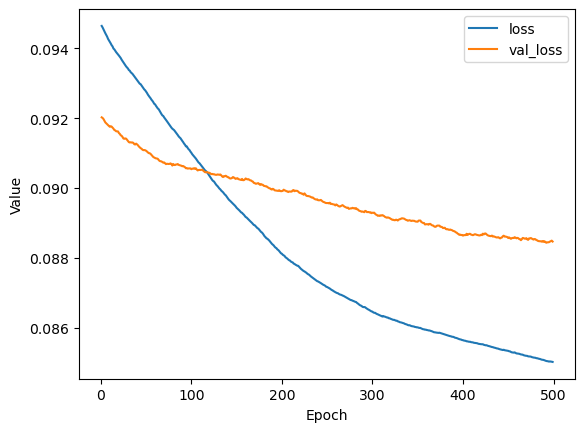

In [91]:
list_of_metrics_to_plot = ['loss','val_loss']
plot_curve(history.epoch, pd.DataFrame(history.history), list_of_metrics_to_plot)

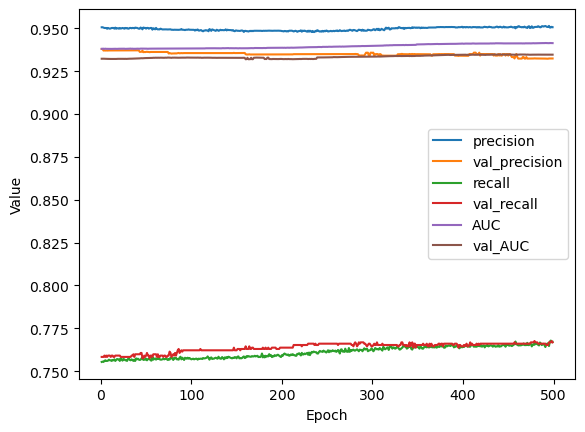

In [92]:
list_of_metrics_to_plot = ['precision','val_precision','recall','val_recall','AUC','val_AUC']
plot_curve(history.epoch, pd.DataFrame(history.history), list_of_metrics_to_plot)

In [88]:
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed.head()

,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
3737323,0.250094,-0.281447,-0.172269,-0.190799,-0.300451,1.0,0.0,0.0,0.0,0.0,1.0,0.0
264914,-0.279431,-0.278155,-0.285989,-0.324181,-0.333782,0.0,0.0,0.0,1.0,0.0,0.0,1.0
85647,-0.045699,-0.251754,-0.203827,-0.264833,-0.320406,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5899326,2.280522,-0.288675,-0.292395,0.618756,0.961809,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2544263,-0.168854,0.723236,0.733907,-0.201589,-0.241688,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [93]:
test_scores = simple_model.evaluate(X_test_transformed, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test root mean squared error:", test_scores[1])

39767/39767 - 47s - loss: 0.0334 - root_mean_squared_error: 0.0786 - recall: 0.7685 - precision: 0.1781 - AUC: 0.5603 - 47s/epoch - 1ms/step
Test loss: 0.033423855900764465
Test root mean squared error: 0.07861153781414032


In [94]:
test_predictions = simple_model.predict(X_test_transformed)

39767/39767 [==============================] - 48s 1ms/step


Legitimate Transactions Detected (True Negatives):  1265157
Legitimate Transactions Incorrectly Detected (False Positives):  5747
Fraudulent Transactions Missed (False Negatives):  375
Fraudulent Transactions Detected (True Positives):  1245
Total Fraudulent Transactions:  1620


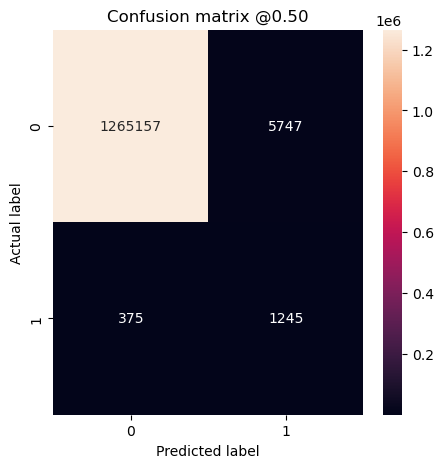

In [95]:
plot_cm(y_test, test_predictions)

In this case the model is already performing better, but the recall is too low. As in our case the cost of false negative is much higher than false positive, something should be done in that regard. Options to try would be undersampling negative examples and using weighed loss.